# Gesture Recognition

### Problem statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

* Thumbs up: Increase the volume
* Thumbs down: Decrease the volume
* Left swipe: 'Jump' backwards 10 seconds
* Right swipe: 'Jump' forward 10 seconds
* Stop: Pause the movie

In [1]:
import numpy as np
import os
import datetime
import os
import cv2
from imageio import imread
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageEnhance

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
from tensorflow import keras 
tf.random.set_seed(30)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

In [3]:
train_doc = np.random.permutation(open('./datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./datasets/Project_data/val.csv').readlines())
batch_size = 30

In [4]:
# Parameters initialization
nb_rows = 120   # X dimension of the image
nb_cols = 120   # Y dimesnion of the image
total_frames = 30
nb_frames = 30  # lenght of the video frames
nb_channel = 3 # numbe rof channels in images 3 for color(RGB) and 1 for Gray
enable_augmentation = False 
# selecting alternate frames from 7 to 26.
seq_idx = range(7,26,2)
# image dimensions
dim_x, dim_y = 120, 120

## Generator


In [5]:
# generator with augmentation for train data
def generator(source_path, folder_list, batch_size, is_train = False, augmention = False, debug=False):
    # print('\nSource path = ', source_path, '; batch size =', batch_size)
    img_idx = seq_idx #create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y, z = dim_x, dim_y
    while True:
        # doubling the data for augmentation
        if is_train and augmention:
            t = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            t = np.random.permutation(folder_list)
            
        if (len(t)%batch_size) == 0:
            num_batches = int(len(t)/batch_size)
        else:
            num_batches = len(t)//batch_size + 1
            
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                if debug:
                    plt.figure(figsize=(20,5))
                #handling remaining datapoints
                folder_idx = folder + (batch*batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                imgs = os.listdir(source_path+'/'+ folder_str.split(';')[0]) # read all the images in the folder
                # randomly enabling augmentation and augmentation type
                aug_type = None
                if is_train and augmention and rn.randint(0,1) == 1:
                    aug_type = rn.randint(0, 4) #randomly selecting augmentation type
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item], cv2.IMREAD_COLOR)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    # plotting original images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+1)
                        plt.imshow(image.astype('uint8'))

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # making the rectangle images into square by cropping sides
                    # so the aspect ration can be mantained while resizing.
                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]

                    resized_im = cv2.resize(image, (nb_rows,nb_cols), interpolation = cv2.INTER_AREA)

                    if aug_type is not None:
                        if aug_type == 0: # edge Enhancement
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.EDGE_ENHANCE))
                        elif aug_type == 1: # adding gaussian blur
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.GaussianBlur(1)))
                        elif aug_type == 2: # enchancing image detailing
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.DETAIL))
                        elif aug_type == 3: # sharpening image
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.SHARPEN))
                        elif aug_type == 4: # Brightness enhancement
                            resized_im = np.array(ImageEnhance.Brightness((Image.fromarray(resized_im, 'RGB'))).enhance(1.5))
                    # plotting rezised images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+x+1)
                        plt.imshow(resized_im)

                    batch_data[folder,idx,:,:,0] = resized_im[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_im[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_im[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(folder_str.strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
                

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = './datasets/Project_data/train'
val_path = './datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


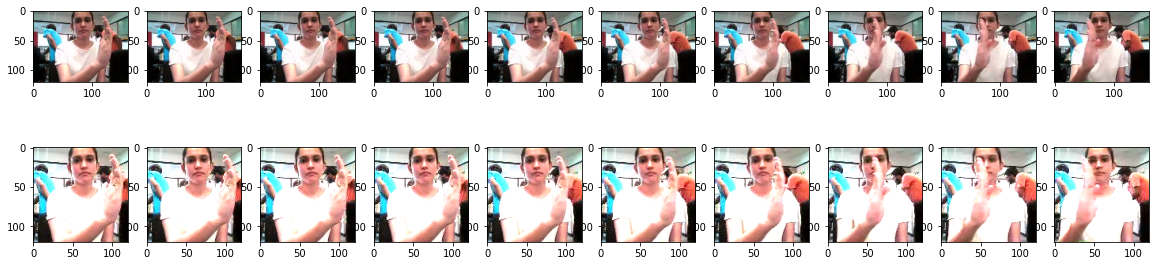

In [7]:
# testing generative 
test_gen = generator(train_path, train_doc, 1, is_train = True, augmention = True, debug = True)
d = next(test_gen)[1]

## Model


In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout,GlobalAveragePooling2D,GlobalAveragePooling3D
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers.convolutional_recurrent import ConvLSTM2D

#input shape
input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

##### For plotting purpose

In [9]:
import matplotlib.pyplot as plt


def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

Experiment - 1 & 2

**Conv3D**

In [10]:
#model = Sequential()
#model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
#model.add(MaxPooling3D(pool_size=2))

#model.add(Conv3D(64, kernel_size=3, activation='relu'))
#model.add(MaxPooling3D(pool_size=2))

#model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(Dense(5, activation='softmax'))

Experiment - 3

**Conv3D**

In [11]:
#model = Sequential()

#model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
#model.add(Conv3D(64, kernel_size=3, activation='relu'))
#model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model.add(Conv3D(128, kernel_size=3, activation='relu'))
#model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu'))
#model.add(MaxPooling3D(pool_size=(3, 2, 2)))

#model.add(Conv3D(512, kernel_size=(3, 3, 3), activation='relu'))
#model.add(Conv3D(512, kernel_size=(3, 3, 3), activation='relu'))
#model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model.add(Flatten())
#model.add(Dense(512, activation='relu'))
#model.add(Dense(5, activation='softmax'))

Experiment - 4

**Conv3D**

In [12]:
#model = Sequential()

#model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
#model.add(Conv3D(64, kernel_size=3, activation='relu'))
#model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#model.add(Conv3D(128, kernel_size=3, activation='relu'))
#model.add(MaxPooling3D(pool_size=(1, 2, 2)))

#model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
#model.add(MaxPooling3D(pool_size=(1, 2, 2)))

#model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
#model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
#model.add(MaxPooling3D(pool_size=(1, 2, 2)))

#model.add(Flatten())
#model.add(Dense(512, activation='relu'))
#model.add(Dense(5, activation='softmax'))

Experiment - 5 with 30 epochs & 
Experiment - 6 with 50 epochs

**Conv3D**

In [13]:
#model = Sequential()

#model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
#model.add(Conv3D(64, kernel_size=3, activation='relu'))
#model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model.add(BatchNormalization())

#model.add(Conv3D(128, kernel_size=3, activation='relu'))
#model.add(MaxPooling3D(pool_size=(1, 2, 2)))
#model.add(BatchNormalization())

#model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
#model.add(MaxPooling3D(pool_size=(1, 2, 2)))
#model.add(BatchNormalization())

#model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
#model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
#model.add(MaxPooling3D(pool_size=(1, 2, 2)))
#model.add(BatchNormalization())

#model.add(Flatten())
#model.add(Dense(512, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dense(5, activation='softmax'))

Experiment - 7

**Conv3D**

In [14]:
#model = Sequential()

#model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
#model.add(Conv3D(64, kernel_size=3, activation='relu'))
#model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))


#model.add(Conv3D(128, kernel_size=3, activation='relu'))
#model.add(MaxPooling3D(pool_size=(1, 2, 2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))


#model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
#model.add(MaxPooling3D(pool_size=(1, 2, 2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))


#model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
#model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
#model.add(MaxPooling3D(pool_size=(1, 2, 2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))


#model.add(Flatten())
#model.add(Dense(512, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dense(5, activation='softmax'))

Experiment - 8

**Conv3D**

In [15]:
#model = Sequential()

#model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
#model.add(Conv3D(64, kernel_size=3, activation='relu'))
#model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))

#model.add(Conv3D(128, kernel_size=3, activation='relu'))
#model.add(MaxPooling3D(pool_size=(1, 2, 2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))

#model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
#model.add(MaxPooling3D(pool_size=(1, 2, 2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))

#model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
#model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
#model.add(MaxPooling3D(pool_size=(1, 2, 2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))

#model.add(Flatten())
#model.add(Dense(512, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dense(5, activation='softmax'))

Experiment - 9

**Conv3D**

In [16]:
#model = Sequential()

#model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
#model.add(Conv3D(64, kernel_size=3, activation='relu'))
#model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))

#model.add(Conv3D(128, kernel_size=3, activation='relu'))
#model.add(MaxPooling3D(pool_size=(1, 2, 2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))

#model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
#model.add(MaxPooling3D(pool_size=(1, 2, 2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))

#model.add(Flatten())
#model.add(Dense(512, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dense(5, activation='softmax'))

Experiment - 10

**Conv3D**

In [17]:
#loss: 0.0198 
#categorical_accuracy: 0.9551 
#val_loss: 2.5496 
#val_categorical_accuracy: 0.4167
    

#model = Sequential()

#model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
#model.add(Conv3D(64, kernel_size=3, activation='relu'))
#model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))

#model.add(Conv3D(128, kernel_size=3, activation='relu'))
#model.add(MaxPooling3D(pool_size=(1, 2, 2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))

#model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
#model.add(MaxPooling3D(pool_size=(1, 2, 2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))

#model.add(GlobalAveragePooling3D())
#model.add(Dense(512, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dense(5, activation='softmax'))

Experiment - 11

**TimeDistributed Conv2D + GRU**

In [18]:
#model = Sequential()
#model.add(TimeDistributed(
#     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
#)
#model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
#)
#model.add(BatchNormalization())

#model.add(TimeDistributed(
#     Conv2D(64, (3,3), activation='relu'))
#)
#model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
#)
#model.add(BatchNormalization())

#model.add(TimeDistributed(GlobalAveragePooling2D()))
#model.add(TimeDistributed(Dense(64, activation='relu')))
#model.add(BatchNormalization())

#model.add(GRU(128))
#model.add(BatchNormalization())
#model.add(Dense(5, activation='softmax'))

Experiment - 12

**TimeDistributed Conv2D + GRU**

In [19]:
#model = Sequential()
#model.add(TimeDistributed(
#     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
#)
#model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
#)
#model.add(BatchNormalization())
#model.add(Dropout(0.2))

#model.add(TimeDistributed(
#     Conv2D(64, (3,3), activation='relu'))
#)
#model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
#)
#model.add(BatchNormalization())
#model.add(Dropout(0.2))

#model.add(TimeDistributed(GlobalAveragePooling2D()))
#model.add(TimeDistributed(Dense(64, activation='relu')))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))

#model.add(GRU(128))
#model.add(BatchNormalization())
#model.add(Dense(5, activation='softmax'))

Experiment - 13

**TimeDistributed Conv2D + Dense**

In [20]:
#model = Sequential()
#model.add(TimeDistributed(
#     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
#)
#model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
#)
#model.add(BatchNormalization())

#model.add(TimeDistributed(
#     Conv2D(64, (3,3), activation='relu'))
#)
#model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
#)
#model.add(BatchNormalization())

#model.add(TimeDistributed(
#     Conv2D(128, (3,3), activation='relu'))
#)
#model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
#)
#model.add(BatchNormalization())

#model.add(GlobalAveragePooling3D())
#model.add(Dense(256, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dense(5, activation='softmax'))

 Experiment - 14
 
**TimeDistributed + ConvLSTM2D**

In [21]:
# model = Sequential()
# model.add(TimeDistributed(
#     Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
# )
# model.add(BatchNormalization())
# model.add(TimeDistributed(
#     Conv2D(16, (3,3), activation='relu'))
# )
# model.add(BatchNormalization())
# model.add(
#     ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
# )
# model.add(BatchNormalization())
# model.add(TimeDistributed(
#     Dense(64, activation='relu'))
# )
# model.add(BatchNormalization())
# model.add(GlobalAveragePooling2D())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(5, activation='softmax'))

# Final Model

In [22]:
model = Sequential()
model.add(TimeDistributed(
   Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

2023-08-07 18:32:10.183302: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-08-07 18:32:10.183366: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14796 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [23]:
from tensorflow.keras.optimizers import Adam
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 118, 118, 8)  224       
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, 10, 118, 118, 8)  32        
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 116, 116, 16)  1168     
 tributed)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, 10, 116, 116, 16)  64       
 hNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 114, 114, 8)       6

In [24]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmention = False)
val_generator = generator(val_path, val_doc, batch_size)

In [25]:
model_name = 'model_init_exp_15' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [26]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [27]:
final_model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_2322/1446177128.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  final_model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/30


2023-08-07 18:32:14.893848: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 1.4328 - categorical_accuracy: 0.3116
Epoch 00001: saving model to model_init_exp_15_2023-08-0718_32_07.500042/model-00001-1.43275-0.31159-1.34189-0.14167.h5
23/23 [==============================] - 25s 869ms/step - loss: 1.4328 - categorical_accuracy: 0.3116 - val_loss: 1.3419 - val_categorical_accuracy: 0.1417 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.1991 - categorical_accuracy: 0.4362
Epoch 00002: saving model to model_init_exp_15_2023-08-0718_32_07.500042/model-00002-1.19907-0.43623-1.32686-0.14167.h5
23/23 [==============================] - 19s 844ms/step - loss: 1.1991 - categorical_accuracy: 0.4362 - val_loss: 1.3269 - val_categorical_accuracy: 0.1417 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.0868 - categorical_accuracy: 0.4971
Epoch 00003: saving model to model_init_exp_15_2023-08-0718_32_07.500042/model-00003-1.08682-0.49710-1.32337-0.2583

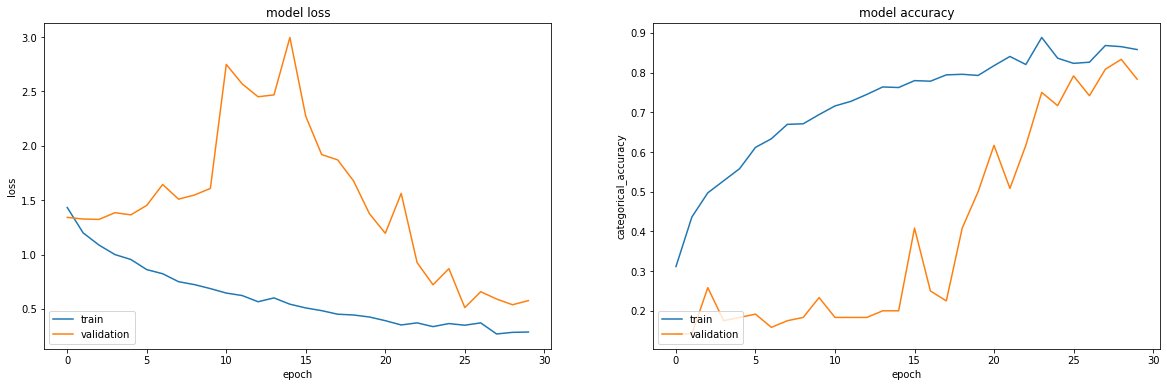

In [28]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(final_model_history.history['loss'])
ax1 = plt.plot(final_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(final_model_history.history['categorical_accuracy'])
ax2 = plt.plot(final_model_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')